In [1]:
cycle = 1
seeding_dataset = 'data/ChemBL-35-cleaned.csv' # initialized with 50k-ChemBL.csv

trainingset_path  = 'data/'+str(cycle)+'-training_set_org.csv'  
charset_path= 'data/1-0.001-inp.h5'
latent_dataset_path = 'data/'+str(cycle)+'-training_set_latent_space.csv'
PATH = "01-attempt-Feb2025/checkpoint_239.pth"

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from group_selfies import (
    fragment_mols, 
    Group, 
    MolecularGraph, 
    GroupGrammar, 
    group_encoder
)

from rdkit.Chem import rdmolfiles
from rdkit.Chem.Draw import IPythonConsole

import IPython.display # from ... import display
from test_utils import *
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*') 

import os
import sys
from rdkit.Chem import RDConfig
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
from rdkit.Chem import QED

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import gzip
import pandas as pd
import h5py
import numpy as np
from __future__ import print_function
import argparse
import os
import h5py
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import model_selection


def one_hot_array(i, n):
    return map(int, [ix == i for ix in xrange(n)])

def one_hot_index(vec, charset):
    return map(charset.index, vec)

def from_one_hot_array(vec):
    oh = np.where(vec == 1)
    if oh[0].shape == (0, ):
        return None
    return int(oh[0][0])

def decode_smiles_from_indexes(vec, charset):
    # Ensure that each element in 'vec' is a string (not numpy.bytes_)
    return "".join(map(lambda x: str(charset[x], 'utf-8') if isinstance(charset[x], bytes) else charset[x], vec)).strip()

def load_dataset(filename, split = True):
    h5f = h5py.File(filename, 'r')
    if split:
        data_train = h5f['data_train'][:]
    else:
        data_train = None
    data_test = h5f['data_test'][:]
    charset =  h5f['charset'][:]
    h5f.close()
    if split:
        return (data_train, data_test, charset)
    else:
        return (data_test, charset)

class MolecularVAE(nn.Module):
    def __init__(self):
        super(MolecularVAE, self).__init__()

        self.conv_1 = nn.Conv1d(120, 9, kernel_size=9)
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)
        self.linear_0 = nn.Linear(280, 435) # changed from 70 to 280 to reflect the change of charset size
        self.linear_1 = nn.Linear(435, 292)
        self.linear_2 = nn.Linear(435, 292)
        
        self.linear_3 = nn.Linear(292, 292)
        self.gru = nn.GRU(292, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, 54) # changed this output from 33 to 54 to reflect the larger charset size
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def encode(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        return self.linear_1(x), self.linear_2(x)

    def sampling(self, z_mean, z_logvar):
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 120, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.sampling(z_mean, z_logvar)
        return self.decode(z), z_mean, z_logvar


def load_dataset_chunked(filename, split=True, batch_size=10000):
    # Open the HDF5 file explicitly
    h5f = h5py.File(filename, 'r')

    # Memory-mapping the data (this avoids loading the entire dataset into memory at once)
    data_test = np.array(h5f['data_test'], dtype='float32', copy=False)
    
    # Handle charset as strings directly
    charset = h5f['charset']
    if charset.dtype.kind in {'S', 'O'}:  # If it's a string or object type
        charset = [x.decode('utf-8') if isinstance(x, bytes) else x for x in charset]  # Decode bytes if needed
    else:
        charset = np.array(charset, dtype='float32', copy=False)
    
    if split:
        # Instead of loading the entire data_train, we'll iterate in chunks
        data_train = h5f['data_train']
        total_samples = data_train.shape[0]
        
        # Define the generator that reads data in chunks
        def data_batch_generator():
            """Generator to load data in batches."""
            for i in range(0, total_samples, batch_size):
                batch = data_train[i:i+batch_size]  # Read a batch from disk
                yield batch

        # Return the generator, data_test, and charset
        return (data_batch_generator(), data_test, charset)
    else:
        # If not splitting, return data_test and charset only
        return (data_test, charset)
    
    # Don't forget to close the file manually when done
    h5f.close()

In [4]:
import time
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MolecularVAE().to(device)

torch.manual_seed(42)

class dotdict(dict): 
  __getattr__ = dict.get
  __setattr__ = dict.__setitem__
  __delattr__ = dict.__delitem__

args = dotdict()

/home/jameshko/anaconda3/envs/pytorch_cuda_tensorflow/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
checkpoint = torch.load(PATH, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
train_losses_p = checkpoint['train_losses_p']
val_losses_p = checkpoint['val_losses_p']

model.eval()

MolecularVAE(
  (conv_1): Conv1d(120, 9, kernel_size=(9,), stride=(1,))
  (conv_2): Conv1d(9, 9, kernel_size=(9,), stride=(1,))
  (conv_3): Conv1d(9, 10, kernel_size=(11,), stride=(1,))
  (linear_0): Linear(in_features=280, out_features=435, bias=True)
  (linear_1): Linear(in_features=435, out_features=292, bias=True)
  (linear_2): Linear(in_features=435, out_features=292, bias=True)
  (linear_3): Linear(in_features=292, out_features=292, bias=True)
  (gru): GRU(292, 501, num_layers=3, batch_first=True)
  (linear_4): Linear(in_features=501, out_features=54, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
)

In [6]:
_, _, charset = load_dataset(charset_path)

In [7]:
training_set_org = pd.read_csv(trainingset_path)

In [8]:
training_set_org.describe()

,QED,SA_score
count,2376.000000,2376.000000
mean,0.945251,2.539181
std,0.001352,0.519882
min,0.943216,1.459705
25%,0.944030,2.129856
50%,0.945134,2.499254
75%,0.946302,2.875382
max,0.948369,4.546399


In [9]:
latent_data = pd.read_csv(latent_dataset_path)

In [10]:
x = np.float32(latent_data)
y = np.float32(training_set_org[['QED']])#, 'SA_score']])

In [11]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, representation, values):
        'Initialization'
        self.lines = representation
        self.values = values

  def __len__(self):
        'Denotes the total number of samples'
        return self.values.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        y = y_train[index,:]
        x = x_train[index,:]
        return x, y

In [12]:
    data_s1 = training_set_org.sort_values(by=['QED']).dropna(subset=['QED']).drop_duplicates(subset=['QED']).tail(100)
#    data_s2 = training_set_org.sort_values(by=['SA_score'], ascending=True).dropna(subset=['SA_score']).drop_duplicates(subset=['SA_score']).head(100)
    data_s1 = data_s1['QED'].reset_index(drop=True)
#    data_s2 = data_s2['SA_score'].reset_index(drop=True)
#    y_s = np.float32(pd.concat([data_s1, data_s2], axis=1, ignore_index=True))
    y_s = np.float32(data_s1)
    y_s = torch.tensor(y_s).float()

In [13]:
    args.batch_size = 250

In [14]:
    from sklearn.model_selection import train_test_split

    train_ratio = 0.80
    validation_ratio = 0.20
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=1 - train_ratio, random_state=42)

    # Data container:
    training_set = Dataset(y_train, x_train)
    validation_set = Dataset(y_val, x_val)
    train_loader = torch.utils.data.DataLoader(dataset=training_set,  batch_size=args.batch_size,shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=args.batch_size, shuffle=False)

    print('train: ', len(training_set), ', test: ' , len(validation_set), 'sample len: ', len(y_s))

train:  1900 , test:  476 sample len:  100


In [15]:
    flow_train_losses = []
    flow_val_losses = []

    #num_shared_embedding = 50
    num_layers = 4
    hidden_features = 32

In [16]:
import normflows as nf

In [17]:
# Define flows
K = num_layers
torch.manual_seed(0)

latent_size = x_train.shape[1]
hidden_units = hidden_features
hidden_layers = 1

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribuiton
q0 = nf.distributions.DiagGaussian(x_train.shape[1], trainable=False)
    
# Construct flow model
flow = nf.NormalizingFlow(q0=q0, flows=flows)

# Move model on GPU if available
enable_cuda = True
device =  torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
flow = flow.to(device)

In [18]:
# In case of restart:
PATH = "1.1-normflows-MaskedRatQuad-4-32.pth"

checkpoint_flow = torch.load(PATH)#, weights_only=True)
flow.load_state_dict(checkpoint_flow['model_state_dict'])
epoch = checkpoint_flow['epoch']
flow_train_losses = checkpoint_flow['train_losses_p']
flow_val_losses = checkpoint_flow['val_losses_p']

flow.train()

NormalizingFlow(
  (q0): DiagGaussian()
  (flows): ModuleList(
    (0): AutoregressiveRationalQuadraticSpline(
      (mprqat): MaskedPiecewiseRationalQuadraticAutoregressive(
        (autoregressive_net): MADE(
          (preprocessing): Identity()
          (initial_layer): MaskedLinear(in_features=292, out_features=32, bias=True)
          (blocks): ModuleList(
            (0): MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=32, out_features=32, bias=True)
              )
              (activation): ReLU()
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=32, out_features=6716, bias=True)
        )
      )
    )
    (1): LULinearPermute(
      (permutation): _RandomPermutation()
      (linear): _LULinear()
    )
    (2): AutoregressiveRationalQuadraticSpline(
      (mprqat): MaskedPiecewiseRationalQuadraticAutoregressive(
        (autore

In [19]:
    args.learning_rate = 1.e-4
    args.n_epochs = 10000
    last_epoch = len(flow_train_losses)
    args.log_interval2 = 100 # (args.n_epochs-last_epoch)/100

    # Size and network parameters
    pytorch_total_params_grad = sum(p.numel() for p in flow.parameters() if p.requires_grad)
    print('Total params to optimize:', pytorch_total_params_grad)

    optimizer = optim.Adam(flow.parameters(),
                           lr=args.learning_rate)#, weight_decay=1e-3)
#    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=args.n_epochs)

    torch.cuda.empty_cache()
    flow = flow.cuda()
    
    time0 = time.time()

    for epoch in range(last_epoch +1, args.n_epochs + 1):
        flow.train()
        flow_train_loss = 0
        for batch_idx, (params, datas) in enumerate(train_loader):
            optimizer.zero_grad()
            params = params.to(device)
            #datas = datas.to(device)
            loss = flow.forward_kld(params)
            #loss = -flow.log_prob(inputs= params, conditional=datas).mean()
            loss.backward()
            optimizer.step()
            #scheduler.step()
            flow_train_loss += loss.item()

        flow_train_loss_avg = flow_train_loss #/ len(train_loader.dataset)
        
        # Validation set
        flow.eval()
        flow_val_loss = 0
        for batch_idx, (val_params, val_data) in enumerate(test_loader):
            val_params = val_params.to(device)
            #val_data = val_data.to(device)
            val_loss = flow.forward_kld(val_params)
            #val_loss = -flow.log_prob(inputs=val_params, conditional=val_data).mean()
            flow_val_loss += val_loss.item()

        flow_val_loss_avg = flow_val_loss #/ len(test_loader.dataset)

        flow_val_losses.append(flow_val_loss_avg)
        flow_train_losses.append(flow_train_loss_avg)

        time_it = (time.time()-time0)/60.
        
        if epoch % args.log_interval2 ==0: print('====> Epoch: {} Average loss: {:.4f} Validation loss: {:.4f} Time: {:.3f} min'.format(epoch, flow_train_loss_avg, flow_val_loss_avg, time_it))
            
    print('Training: {0:2.2f} min'.format( (time.time()-time0)/60.))

Total params to optimize: 1274688


/home/jameshko/anaconda3/envs/pytorch_cuda_tensorflow/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training: 0.00 min


In [41]:
PATH = "1.1-normflows-MaskedRatQuad-4-32.pth"

torch.save({
            'epoch': epoch,
            'model_state_dict': flow.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses_p': flow_train_losses,
            'val_losses_p': flow_val_losses,
            }, PATH)

Text(0, 0.5, 'Losses')

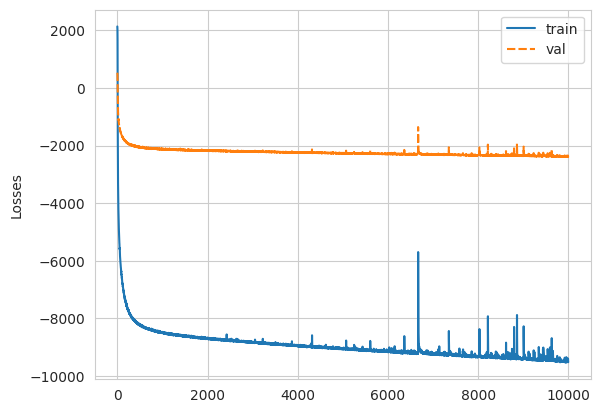

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert tensors to regular Python numbers (floats)
df_losses_dict = {
    'train': [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in flow_train_losses],
    'val': [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in flow_val_losses]
}

# Now you can create the DataFrame
df_losses = pd.DataFrame(df_losses_dict)
# Continue with plotting
sns.set_style("whitegrid")
sns.lineplot(data=df_losses)  # Plots the training and validation losses
plt.ylabel('Losses')
#plt.ylim(-1800, -500)

In [21]:
cycles_of_generated_samples = 20 # 
how_many = 100 # width
range_range = 50 # length of the seeding vector
total_samples = range_range * how_many * cycles_of_generated_samples                                                                                                                                                          
time0 = time.time()
# 34900
print('Number of samples is ', range_range, 'x ',cycles_of_generated_samples, 'x ', how_many)

flow.eval()

conditional = False

with torch.no_grad():
    for i in range(range_range):
        counter = 0
        while counter < cycles_of_generated_samples:
            if conditional == True:    
                conditional_tensor = y_s.to(device).float().unsqueeze(1)
                sample = flow.sample(len(conditional_tensor), conditional=conditional_tensor)
            else:
                sample = flow.sample(how_many)

            # Check if the sample is a tuple and extract the first element (the generated samples)
            if isinstance(sample, tuple):
                generated_samples = sample[0]  # Assuming the first element is the generated samples
            else:
                generated_samples = sample  # If it's not a tuple, use the sample directly

            # Move to CPU and convert to numpy array
            generated_samples = generated_samples.cpu().detach().numpy()
            if i == 0 & counter ==0:
                samples = generated_samples
            else:
                samples = np.vstack([samples, generated_samples])

            counter += 1

        print('sample', i, ', {0:2.2f} min'.format((time.time() - time0) / 60.), samples.shape)

Number of samples is  50 x  20 x  100
sample 0 , 6.83 min (100, 292)
sample 1 , 13.36 min (2100, 292)
sample 2 , 19.77 min (4100, 292)
sample 3 , 26.19 min (6100, 292)
sample 4 , 32.60 min (8100, 292)
sample 5 , 38.98 min (10100, 292)
sample 6 , 45.38 min (12100, 292)
sample 7 , 51.78 min (14100, 292)
sample 8 , 60.53 min (16100, 292)
sample 9 , 73.77 min (18100, 292)
sample 10 , 86.89 min (20100, 292)
sample 11 , 100.17 min (22100, 292)
sample 12 , 113.39 min (24100, 292)
sample 13 , 126.59 min (26100, 292)
sample 14 , 139.84 min (28100, 292)
sample 15 , 153.01 min (30100, 292)
sample 16 , 166.23 min (32100, 292)
sample 17 , 179.49 min (34100, 292)
sample 18 , 190.38 min (36100, 292)
sample 19 , 202.86 min (38100, 292)
sample 20 , 211.79 min (40100, 292)
sample 21 , 219.45 min (42100, 292)
sample 22 , 227.12 min (44100, 292)
sample 23 , 234.78 min (46100, 292)
sample 24 , 242.44 min (48100, 292)
sample 25 , 250.13 min (50100, 292)
sample 26 , 257.79 min (52100, 292)
sample 27 , 265.45

In [22]:
samples.shape

(98100, 292)

In [23]:
np.savetxt("zzz.csv", samples, delimiter=",")

In [24]:
backup = samples

In [25]:
    #samples_transformed = np.array(samples)
    samples_t = np.array(samples)#.cpu())
    try:
        samples_transformed = samples_t[:, :] # those generated from high QED
#        samples_2 = samples[:, 1, :] # those generated of the same lengths
#        samples_transformed = np.concatenate((samples_1, samples_2), axis=0) # 50 min for 200 samples
        print(samples_transformed.shape, 'Conditional sampling: {0:2.2f} min'.format( (time.time()-time0)/60.))
    except:
        print(samples_transformed.shape, 'Sampling: {0:2.2f} min'.format( (time.time()-time0)/60.))

(98100, 292) Conditional sampling: 456.56 min


In [28]:
number_of_splits = samples.shape[0]/100
split = np.array_split(samples, number_of_splits, axis=0)  # Split into X chunks along rows

def process_decoding(part):
    return np.float32(model.decode(torch.tensor(part).float().cuda()).cpu()) # decode in segments

model.eval()
with torch.no_grad():
    processed_part = [process_decoding(iterator) for iterator in split] # apply function

samples_decoded = np.vstack(processed_part) # combined together 

In [29]:
all_smiles = []
valid_smiles = []

for id, molecule in enumerate(samples_decoded):
    all_smiles.append(decode_smiles_from_indexes(molecule.reshape(1, 120, len(charset)).argmax(axis=2)[0], charset))

for smi in all_smiles:
    m = Chem.MolFromSmiles(smi,sanitize=False)
    if m is None:
        pass
    else:
        try:
            Chem.SanitizeMol(m)
            valid_smiles.append(smi)
        except:
            pass

print('%.2f' % (len(valid_smiles) / len(all_smiles)*100),  '% of generated samples are valid samples, where all smiles is ', len(all_smiles))

0.70 % of generated samples are valid samples, where all smiles is  98100


In [30]:
all_smiles[10]

'C==CC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'

In [31]:
from collections import OrderedDict
unique_smiles = OrderedDict((x, True) for x in valid_smiles).keys()
print('%.2f' % (len(unique_smiles) / len(all_smiles)*100),  '% of generated samples are unique samples.')

0.57 % of generated samples are unique samples.


In [32]:
print('Calculating QED/SAS for ', len(unique_smiles), ' molecules out of all samples')
df_generated = pd.DataFrame(unique_smiles, columns=["Original_SMILES"]).drop_duplicates(subset=['Original_SMILES'])
for index, row in df_generated.iterrows():
        try:
            mol = Chem.MolFromSmiles(row['Original_SMILES'])#+'OP(C)(=O)F')
            qed = QED.default(mol)
            try:
                sas_score = sascorer.calculateScore(mol)
            except:
                sas_score = np.nan
        except:
            sas_score = np.nan
            qed = np.nan
        
        df_generated.at[index, "QED"] = qed
        df_generated.at[index, "SA_score"] = sas_score
        df_generated.at[index, "Origin"] = str(cycle)+'_iter'

new = df_generated.dropna(subset=['QED', 'SA_score']).sort_values(['QED'], ascending=False)
print('%.2f' % (len(new) / len(all_smiles)*100),  '% of generated samples are unique samples with QED/SAS scores.')

Calculating QED/SAS for  559  molecules out of all samples
0.57 % of generated samples are unique samples with QED/SAS scores.


In [33]:
new

,Original_SMILES,QED,SA_score,Origin
289,Cn1nccc1Oc1ccc(C)ncC(CO)c2Cnc1CO2,0.905832,5.947174,1_iter
155,OCC1cnc(CC2CCC)c2CN(c1ncnc(c1)CC)N1,0.895819,4.795862,1_iter
239,Cc1ccccc1C1=NCCCCCCCc2c1cc(OCC)c(=O)n2CN,0.875289,3.191708,1_iter
74,COCC1=Cn=Nc(Cc2nnc(C(C)O)cccccc2)N1,0.867519,4.568025,1_iter
400,Cc1ccn(CNc2ncc(N=CCcccc(ccc3C)c32))c1O,0.864812,4.623729,1_iter
...,...,...,...,...
200,SOSNNNNNCNCCCNCNCNCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,0.005151,5.299337,1_iter
505,N=NICICCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,0.005113,6.027141,1_iter
10,NCIIIIINIIIINIIIIIIIIININIIIIIIIIIIIIIIIIIIIII...,0.005113,9.166788,1_iter
168,N=NINNCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.005113,7.138449,1_iter


In [34]:
named = '1.1-normflows-MaskedRatQuad-4-32.csv'
new.to_csv(named, index=False)

# Are these datapoints new?

In [35]:
import pandas as pd
all_examples = pd.read_csv(seeding_dataset, index_col=0)
#all_examples['Origin'] = "ChEMBL22-50k"
all_examples['Origin'] = "ChEMBL35"

In [36]:
duplicates = pd.merge(all_examples, new, on=['Original_SMILES'], how='inner')
print('out of ', len(unique_smiles), ' unique samples', len(duplicates), 'were present in the original dataset')

out of  559  unique samples 16 were present in the original dataset


In [37]:
print('previous dataset had ', len(all_examples), ' data points')
formed_new_dataset = pd.merge(all_examples, new, on=['Original_SMILES', 'QED', 'SA_score', 'Origin'], how='outer').drop_duplicates(subset=['Original_SMILES'], keep='first')
formed_new_dataset.to_csv(str(cycle)+'_'+named, index=False)

previous dataset had  2376941  data points


In [38]:
formed_new_dataset

,Original_SMILES,QED,SA_score,Origin
0,Cc1cc(-c2csc(N=C(N)N)n2)cn1C,0.608781,3.048474,ChEMBL35
1,Brc1cccc(Nc2ncnc3ccncc23)c1NCCN1CCOCC1,0.623114,2.595185,ChEMBL35
2,COc1c(O)cc(O)c(C(=N)Cc2ccc(O)cc2)c1O,0.553150,2.658629,ChEMBL35
3,CCOC(=O)c1cc2cc(C(=O)O)ccc2[nH]1,0.794875,1.951981,ChEMBL35
4,C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](C)C(=O)NN...,0.149872,3.746987,ChEMBL35
...,...,...,...,...
2377495,SOSNNNNNCNCCCNCNCNCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,0.005151,5.299337,1_iter
2377496,N=NICICCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,0.005113,6.027141,1_iter
2377497,NCIIIIINIIIINIIIIIIIIININIIIIIIIIIIIIIIIIIIIII...,0.005113,9.166788,1_iter
2377498,N=NINNCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.005113,7.138449,1_iter


In [39]:
formed_new_dataset.sort_values(['QED'], ascending=False)

,Original_SMILES,QED,SA_score,Origin
1022189,C[C@H]1Cc2cc(C(=O)NCc3cnc4c(c3)CCC4)ccc2O1,0.948369,2.748378,ChEMBL35
1000867,CCc1cnccc1C(=O)NC1CC12CCOc1ccccc12,0.948347,3.882271,ChEMBL35
1428851,N=C1SCC(=O)N1c1ncc(Cc2ccc(F)cc2)s1,0.948329,2.721705,ChEMBL35
2244960,Cc1c(Cl)cccc1CNC(=O)C1COc2ncccc21,0.948299,2.968532,ChEMBL35
271224,CN(C)CCC(=O)N1c2ccccc2NC(=O)c2ccccc21,0.948289,2.226372,ChEMBL35
...,...,...,...,...
2377495,SOSNNNNNCNCCCNCNCNCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,0.005151,5.299337,1_iter
2377496,N=NICICCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,0.005113,6.027141,1_iter
2377497,NCIIIIINIIIINIIIIIIIIININIIIIIIIIIIIIIIIIIIIII...,0.005113,9.166788,1_iter
2377498,N=NINNCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.005113,7.138449,1_iter


In [40]:
pd.merge(all_examples, new, on=['Original_SMILES'], how='inner')

,Original_SMILES,QED_x,SA_score_x,Origin_x,QED_y,SA_score_y,Origin_y
0,CCCCCC,0.462954,1.209031,ChEMBL35,0.462954,1.209031,1_iter
1,CCCCCCCCCCCC,0.430464,1.167517,ChEMBL35,0.430464,1.167517,1_iter
2,CCCCCCCCCCC,0.452618,1.194600,ChEMBL35,0.452618,1.194600,1_iter
3,CCCCCCCC,0.480611,1.304763,ChEMBL35,0.480611,1.304763,1_iter
4,CCCCCCCCCCCCCCCC,0.314905,1.094515,ChEMBL35,0.314905,1.094515,1_iter
5,CCCC,0.431024,1.605723,ChEMBL35,0.431024,1.605723,1_iter
6,CCCCCCC,0.476310,1.260713,ChEMBL35,0.476310,1.260713,1_iter
7,CCCCCCCCCCCCCC,0.373104,1.124716,ChEMBL35,0.373104,1.124716,1_iter
8,CCC,0.385471,1.754957,ChEMBL35,0.385471,1.754957,1_iter
9,CCCCCCCCCCCCC,0.403169,1.144365,ChEMBL35,0.403169,1.144365,1_iter
